# What is the variation in $dm$ and $dt$ in our data?

In [1]:
### If Google Colab
# !git config --global user.email "sjs.shamsi@gmail.com"
# !git config --global user.name "SJShamsi"

# from google.colab import drive
# drive.mount('/content/drive')

# Thesis_Files = '/content/drive/MyDrive/Thesis_Files/'

In [2]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [3]:
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
# plt.style.use('seaborn-v0_8-colorblind')

In [4]:
lightcurves_by_name_file = base_directory + "lightcurves_by_name.pkl"
distribution_save_path = base_directory + 'dmdt_Analysis/Equivalent_Bins/'

In [5]:
lightcurves = pd.read_pickle(lightcurves_by_name_file).dropna(axis=0)
# lightcurves = lightcurves[lightcurves['type'].isin(['Q', 'QR', 'QX'])]

# Sampling to save disk space
# lightcurves = lightcurves.sample(frac=0.1)

In [6]:
def large_histogram_one_band(df, quantity_index, lightcurve_key, bins, nchunks, **kwargs):
    hist = np.zeros(shape=(bins.size - 1, ))
    chunks = np.array_split(df, nchunks)
    for chunk in chunks:
        chunk_hist, _ = np.histogram(np.concat(chunk[lightcurve_key].apply(lambda lightcurve: return_dquantities(lightcurve[:, quantity_index])).to_numpy()), bins=bins, **kwargs)
        hist += chunk_hist
    return hist, bins

def large_histogram(df, mode, quantity, bins, nchunks=10, **kwargs):
    quantity_index_dict = {"time": 0, "mag": 1}
    assert(quantity in quantity_index_dict.keys())
    
    if mode == 'name':
        lightcurve_keys = [f'{band}_lightcurve' for band in ['r', 'g']]
    elif mode == 'oid':
        lightcurve_keys = ['lightcurve']
        
    return [large_histogram_one_band(df, quantity_index_dict[quantity], lightcurve_key, bins, nchunks, **kwargs) for lightcurve_key in lightcurve_keys]

def plot_numpy_histogram(ax, hist, bins, density=True, **kwargs):
    bincentres = (bins[1:] + bins[:-1]) / 2
    binwidths = np.diff(bins)
    hist = hist / hist.sum() if density else hist
    ax.bar(bincentres, hist, width=binwidths, **kwargs)
    return ax

def plot_numpy_step(ax, hist, bins, density=True, **kwargs):
    hist = hist / hist.sum() if density else hist
    ax.step(bins[:-1], hist, where='post', **kwargs)
    return ax

In [7]:
def plot_dquantity_histogram(ax, df, mode, band, quantity, **kwargs):
    quantity_index_dict = {"time": 0, "mag": 1}
    assert(quantity in quantity_index_dict.keys())

    lightcurve_key = f'{band}_lightcurve' if mode == 'name' else 'lightcurve'
    dquantities = df[lightcurve_key].progress_apply(lambda lightcurve: return_dquantities(lightcurve[:, quantity_index_dict[quantity]])).to_numpy()

    return ax.hist(np.concat(dquantities), **kwargs)

In [8]:
QSOs = lightcurves[lightcurves['type'].isin(['Q', 'QR', 'QX'])]
nonQSOs = lightcurves[~lightcurves['type'].isin(['Q', 'QR', 'QX'])]

Qs = lightcurves[lightcurves['type'] == 'Q']
QRs = lightcurves[lightcurves['type'] == 'QR']
QXs = lightcurves[lightcurves['type'] == 'QX']

## $dm$ distribution

/home/shoaib/miniforge3/envs/PSC/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


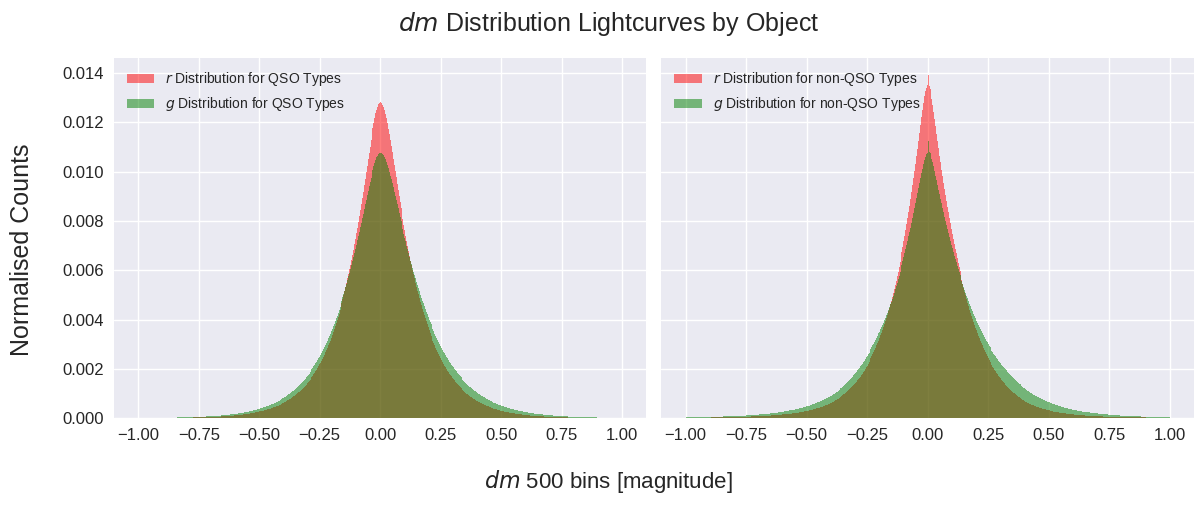

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(-1, 1, 501)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'mag', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, alpha=0.5, color='red', label='$r$ Distribution for QSO Types')
plot_numpy_histogram(axs[0], g_hist, g_bins, alpha=0.5, color='green', label='$g$ Distribution for QSO Types')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'mag', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, alpha=0.5, color='red', label='$r$ Distribution for non-QSO Types')
plot_numpy_histogram(axs[1], g_hist, g_bins, alpha=0.5, color='green', label='$g$ Distribution for non-QSO Types')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper left')
    ax.tick_params(axis='both', which='both', labelsize=12)

fig.supxlabel(f'$dm$ {bins.size - 1} bins [magnitude]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dm$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

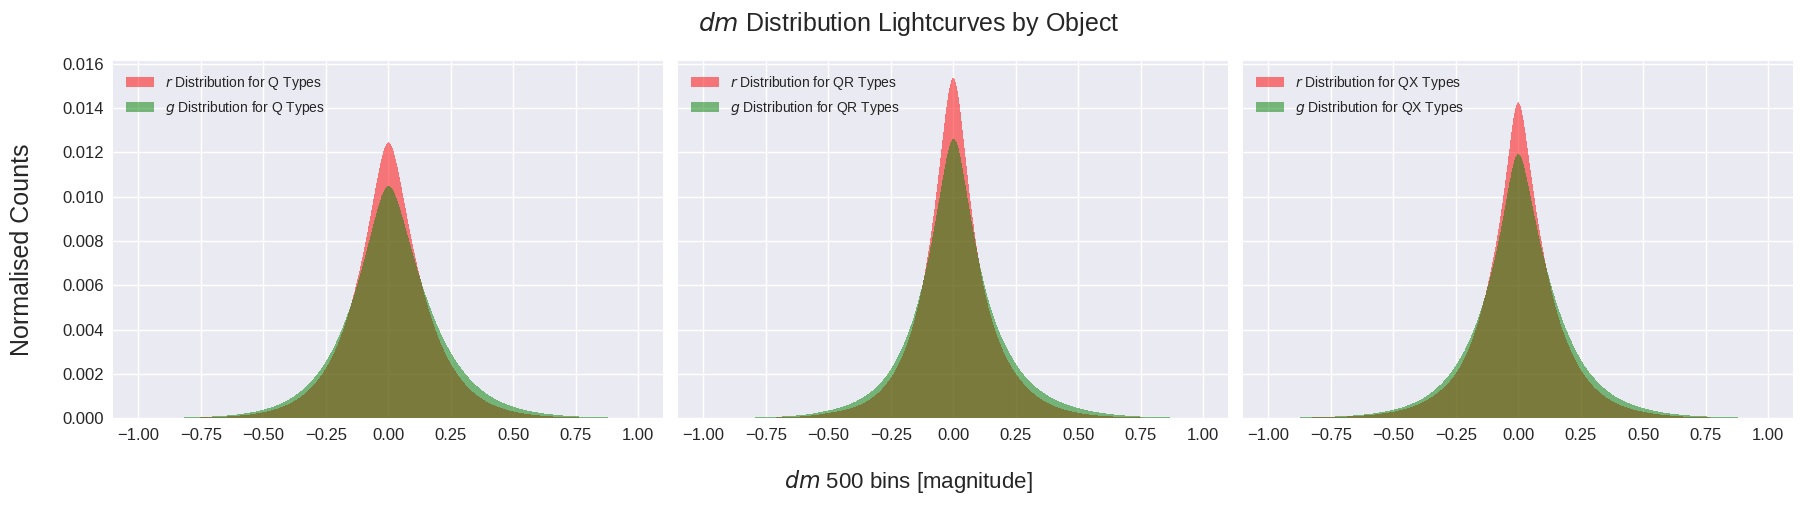

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 1 * 5), sharey=True)
bins = np.linspace(-1, 1, 501)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'mag', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, label='$r$ Distribution for Q Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins, label='$g$ Distribution for Q Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'mag', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, label='$r$ Distribution for QR Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins, label='$g$ Distribution for QR Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'mag', bins)
plot_numpy_histogram(axs[2], r_hist, r_bins, label='$r$ Distribution for QX Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[2], g_hist, g_bins, label='$g$ Distribution for QX Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper left')
    ax.tick_params(axis='both', which='both', labelsize=12)

fig.supxlabel(f'$dm$ {bins.size - 1} bins [magnitude]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dm$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

## $dt$ distribution

### For the range 0 - 2000 days

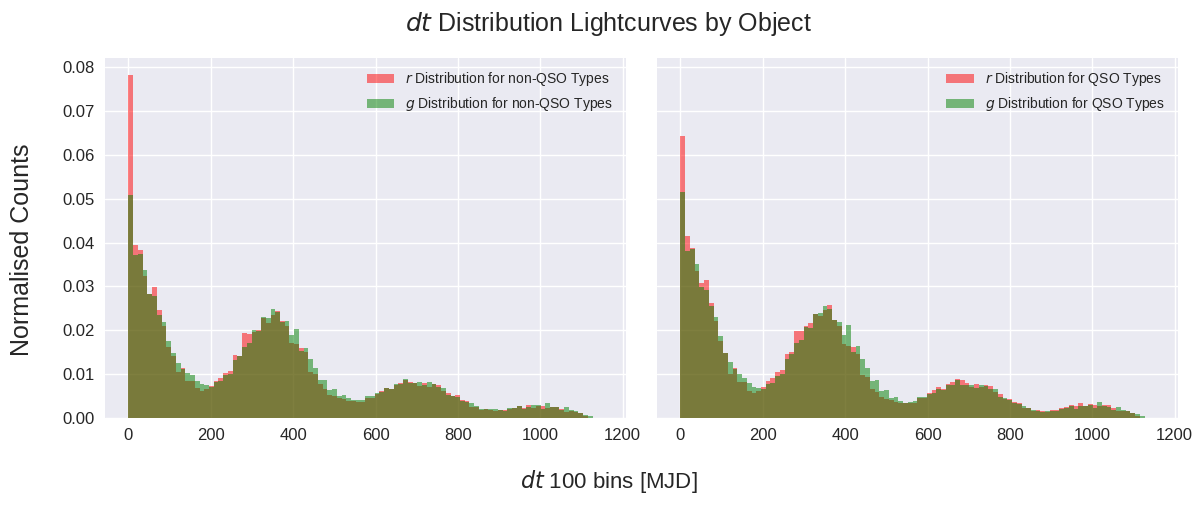

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 1150, 101)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    # ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

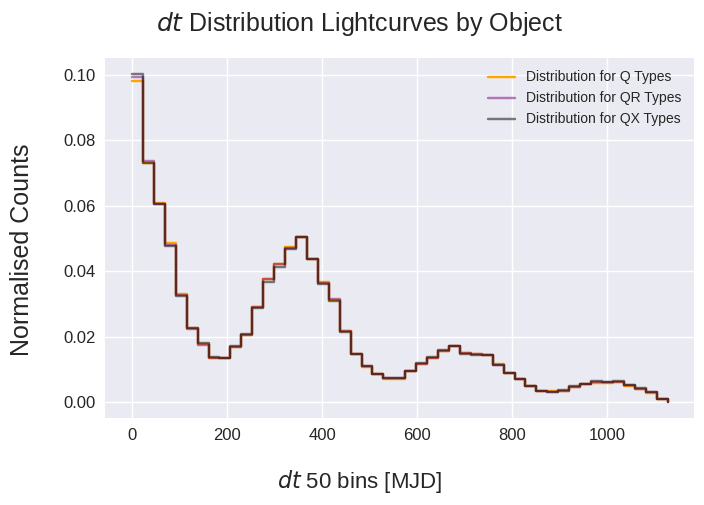

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 1150, 51)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

# ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

### 0 - 2 days

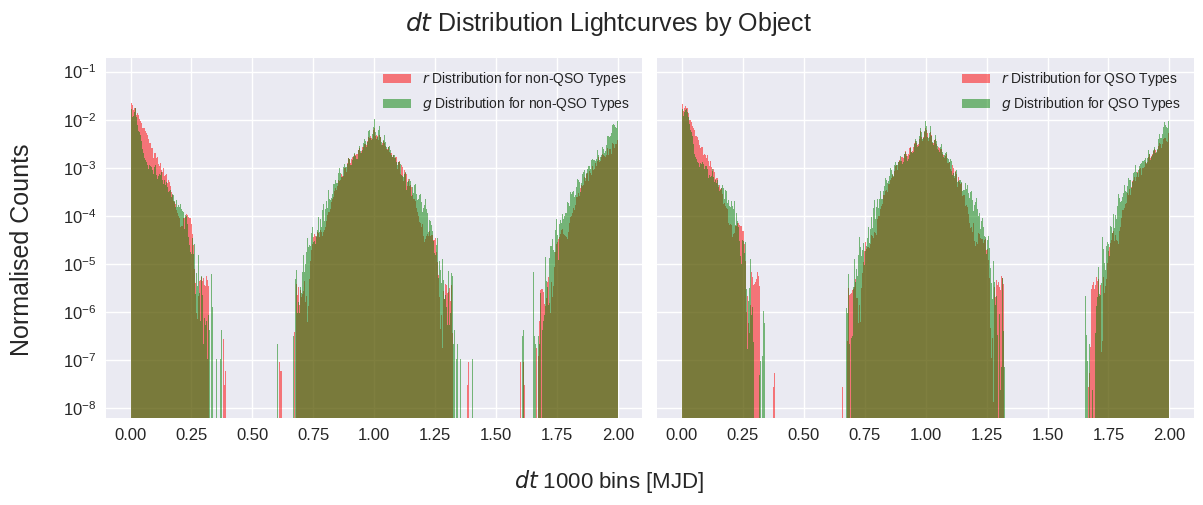

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 2, 1001)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

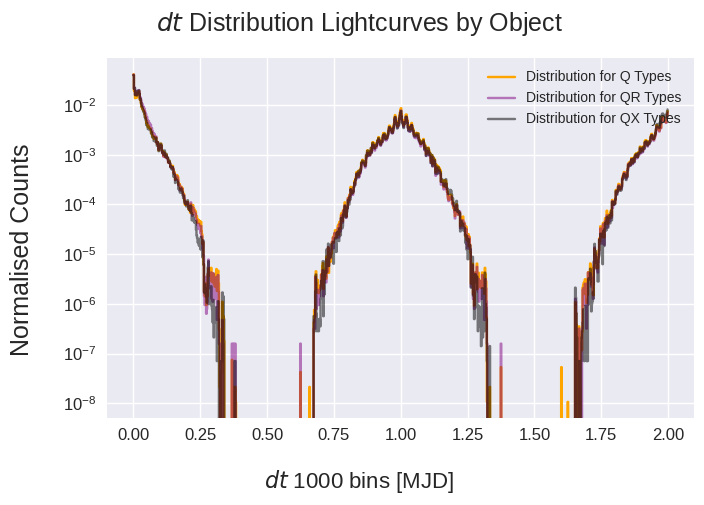

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 2, 1001)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

### 0 - 1 Hour

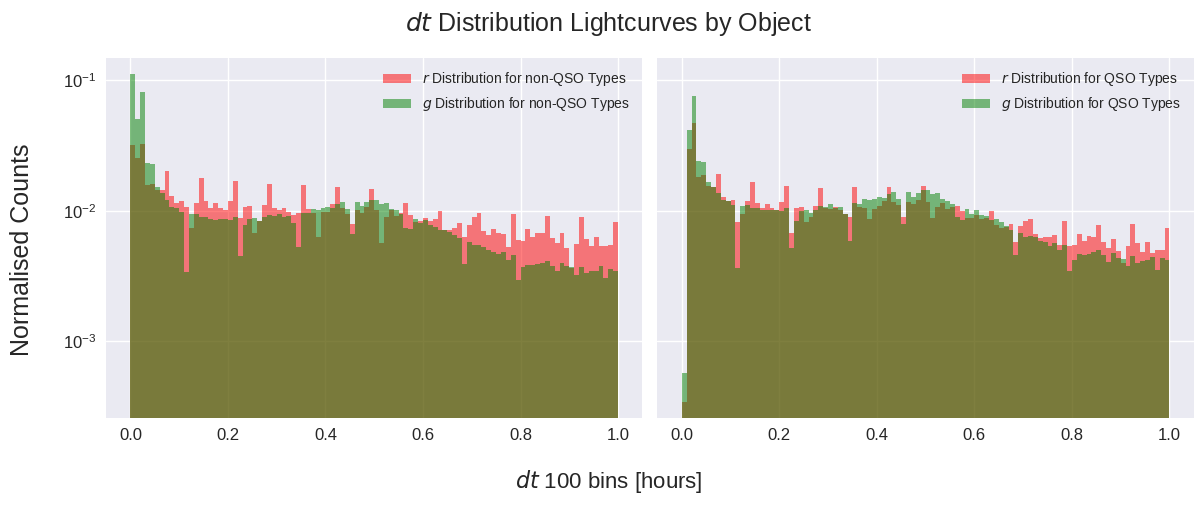

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 1 / 24, 101)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins * 24, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins * 24, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins * 24, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins * 24, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [hours]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

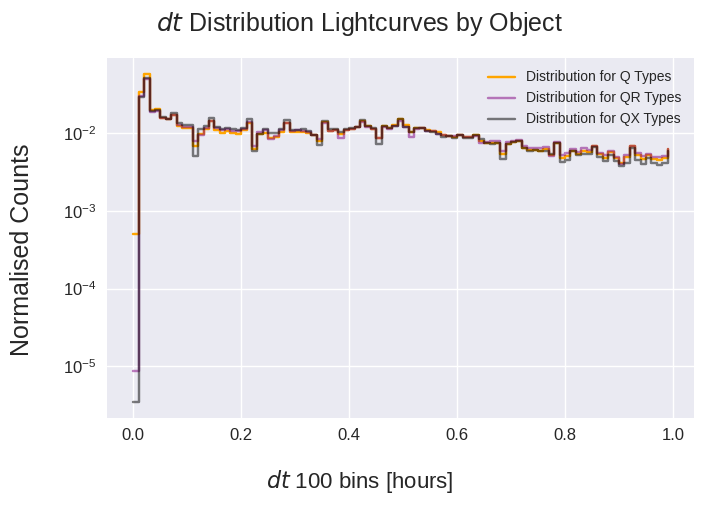

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 1 / 24, 101)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [hours]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

### 0 - 2 Minutes

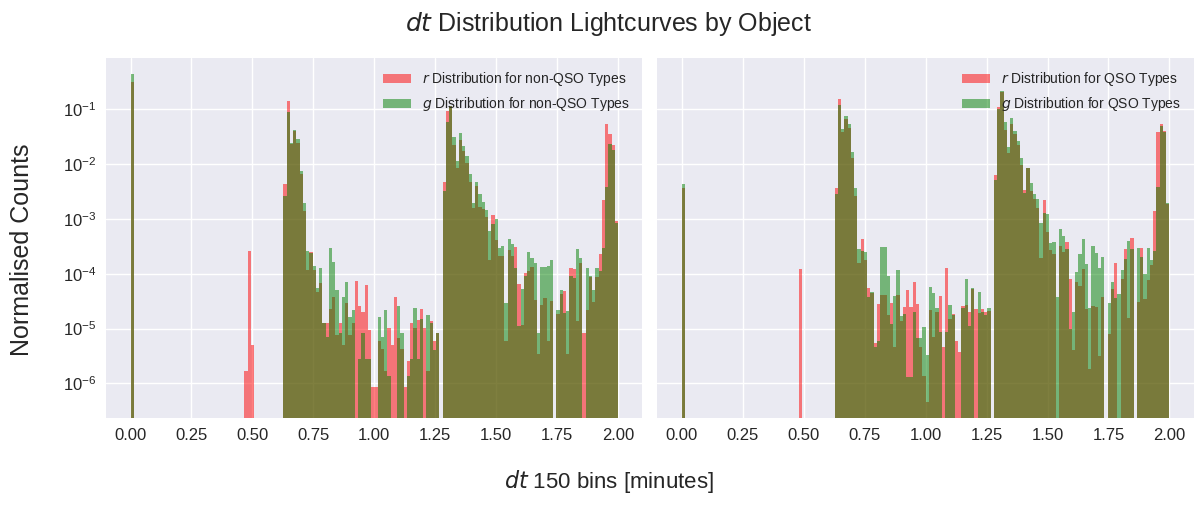

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 2 / (24 * 60), 151)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins * 24 * 60, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins * 24 * 60, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins * 24 * 60, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins * 24 * 60, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [minutes]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

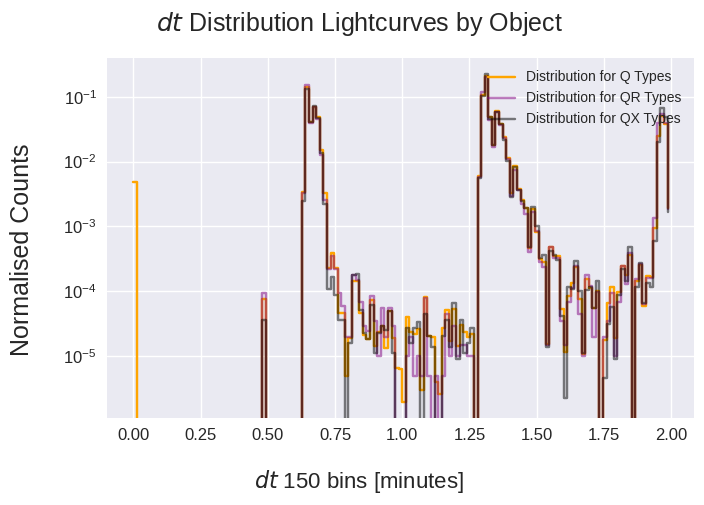

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 2 / (24 * 60), 151)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24 * 60, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24 * 60, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24 * 60, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [minutes]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

We have a couple of dt points at $dt = 0$ as well! That's somehting we need to watch out for. Will this happen even if we consider lightcurves by OID?